In [9]:
import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from nw2vec import utils

/home/sl/.conda/envs/base36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


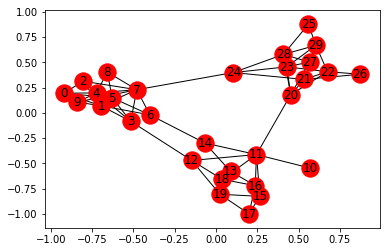

In [6]:
g = nx.planted_partition_graph(3, 10, .5, .01)
nx.draw_networkx(g)

In [7]:
adj = nx.adjacency_matrix(g)
adjeye = adj + np.eye(len(g))

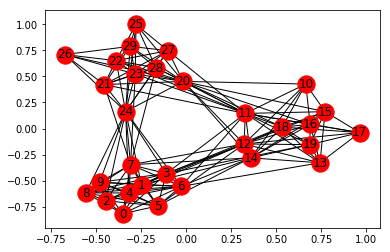

In [8]:
nx.draw_networkx(nx.from_numpy_array(adjeye ** 2))

In [121]:
def max_layer_depth(model, target_layer_class):
    return np.max([_max_layer_depth_from_layer(layer, target_layer_class)
                   for layer in model.output_layers])

def _max_layer_depth_from_layer(layer, target_layer_class):
    inbound_layers = [inlayer
                      for innode in layer._inbound_nodes
                      for inlayer in innode.inbound_layers]
    print(layer)
    print(inbound_layers)
    if len(inbound_layers) == 0:
        parent_depth = 0
    else:
        parent_depth = np.max([_max_layer_depth_from_layer(inlayer, target_layer_class)
                               for inlayer in inbound_layers])
    return isinstance(layer, target_layer_class) + parent_depth

In [118]:
# TODO:
# - allow for sampling of neighbours, i.e. don't take them all or this will grow very fast

def batches(features, adj, neighbour_depth, batch_size):
    # Check the adjacency matrix is:
    # - undirected
    # - unweighted
    # - with no diagonal elements
    n_nodes = adj.shape[0]
    assert len(features) == n_nodes
    assert (adj.T == adj).all()
    assert ((adj == 0) | (adj == 1)).all()
    assert np.trace(adj) == 0
    
    # Get the adjacency matrix for all paths of all lengths <= neighbour_depth
    adj_deep = np.sum([adj ** depth for depth in range(1, neighbour_depth + 1)], axis=0)

    # Shuffle the node indices, to group-iterate through them
    order = np.arange(n_nodes)
    np.random.shuffle(order)

    for batch_ids in utils.grouper(order, batch_size):
        # Prepare batch_ids
        batch_ids = np.array(batch_ids)
        if None in batch_ids:
            # Cut off `None`s
            batch_ids = batch_ids[:np.where(batch_ids == None)[0][0]].astype(order.dtype)
        
        # Get the neighbours of the target nodes
        sorted_neighbour_ids = np.where(adj_deep[batch_ids].sum(0))[0]
        # Merge all the required nodes into a single list, and shuffle that
        all_ids = np.array(list(set(batch_ids).union(sorted_neighbour_ids)))
        np.random.shuffle(all_ids)
        # Recover the indices of the target nodes in our shuffled extended list
        batch_mask = (all_ids[:, None] == batch_ids[None, :]).any(axis=-1)
        
        # Yield:
        # - the row-shuffled matrix of features of the nodes in the batch (with required neighbours included)
        # - the ids *in the previous list* of the target nodes
        # - the adjacency matrix for the nodes in the batch (with required neighbours included),
        #   ordered by the first matrix yielded: the matrix of features can be multiplied with this adjacency matrix.
        yield features[all_ids], np.where(batch_mask)[0], adj[all_ids, :][:, all_ids]

In [120]:
for batch_lists in batches(np.eye(adj.shape[0]), adj.todense(), 2, 4):
    print(batch_lists)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 